In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import xml.etree.ElementTree as ET
import heapq
import math
from timeit import default_timer as timer
import random
import seaborn as sns

In [24]:
data = pd.read_csv('medium.csv', names=['x', 'y'])

### GA Methods

In [25]:
def random_solution(vertices: int) -> list:
    solution = np.random.permutation(vertices)
    # return to first node
    return np.append(solution, solution[0])

def generate_population(population_size: int, vertices: int):
    return [random_solution(vertices)for _ in range(population_size)]

def fitness_function(tour: list, graph):
    cost = 0
    for i in range(len(tour)):
            if i < len(tour) -1:
                cost += graph[tour[i]][tour[i + 1]]
    return cost

def get_population_fitness(population: list, graph):
    return np.array([fitness_function(solution, graph) for solution in population])


def roulette_wheel_selection(population: list, n_selections: int, graph):
    fitness_array = get_population_fitness(population, graph)
    total_fitness = np.sum(fitness_array)
    probabilities = fitness_array / total_fitness

    try:
        indices = np.random.choice(len(fitness_array), n_selections, replace=False, p=probabilities)
    except ValueError:
        print("Fewer non-zero entries in p than size - select mating pool at random")
        indices = np.random.choice(len(fitness_array), n_selections, replace=False)
    # returns the mating pool using probabilities proportional to the fitness of each solution 
    mating_pool = np.array([population[i] for i in indices])
    return mating_pool

def tournament_selection(population: list, n_selections: int, graph):
    fitnesses = get_population_fitness(population, graph)

    indices = []
    for _ in range(n_selections):
        tournament = []
        for _ in range(2):
            tournament.append(math.floor(random.uniform(0, len(fitnesses))))
        
        min_fitness = float("inf")
        for participant in tournament:
            if min_fitness > fitnesses[participant]:
                parent_index = participant
                min_fitness = fitnesses[participant]

        indices.append(parent_index)
    
    mating_pool = np.array([population[i] for i in indices])
    return mating_pool

def feasible_solution(solution):
    """
    Fixes the solution by replacing the duplicate nodes with the missing nodes.
    This can occur when the crossover operation generates a solution with duplicate nodes, or when a mutation operation generates a solution with duplicate nodes.
    """
    temp  = solution.copy()[:-1]
    nodes = np.arange(0, len(temp))
    # print(solution)
    missing_nodes = set(nodes) - set(temp)

    if len(missing_nodes) == 0:
        return solution

    duplicates = [item for item, count in collections.Counter(temp).items() if count > 1]
    duplicates_set = set(duplicates)

    for duplicate in duplicates:
        for i in range(0, len(temp)):
            if temp[i] == duplicate:
                if duplicate in duplicates_set:
                    duplicates_set.remove(duplicate)
                else:
                    temp[i] = missing_nodes.pop()
    # append the first node to the end of the solution

    feasible_solution = np.append(temp, temp[0])
    # print(feasible_solution)
    return feasible_solution

def crossover(parent_1, parent_2):
    """
    Random crossover point is selected and the offspring is generated by swapping the tails of the parents
    """
    n = len(parent_1)

    crossover_point = np.random.randint(1, n)

    offspring_1 = [*parent_1[:crossover_point], *parent_2[crossover_point:]]
    offspring_2 = [*parent_2[:crossover_point], *parent_1[crossover_point:]]

    feasible_1 = feasible_solution(offspring_1)
    feasible_2 = feasible_solution(offspring_2)
    return feasible_1, feasible_2

def mutate_solution(solution, mutation_rate):
    n = len(solution)

    for i in range(n):
        if np.random.rand() < mutation_rate:
            j = np.random.randint(n)
            solution[i], solution[j] = solution[j], solution[i]
    solution[-1] = solution[0]
    solution = feasible_solution(solution)
    return solution


def hill_climber(solution, max_iter, graph):
    n = len(solution)

    for _ in range(max_iter):
        # generate two random indices
        i, j = np.random.choice(n, 2, replace=False)
        new_solution = solution.copy()
        # swap the elements at the two indices to simulate a small change in the solution
        new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
        # greedy acceptance of the new solution
        if fitness_function(new_solution, graph) < fitness_function(solution, graph):
            solution = new_solution

    return solution


### CRISPR operators

In [26]:
def get_best_sequence_in_solution(solution, graph, sequence_length):
    """
    Returns the best sequence in the solution based on the fitness function.
    """
    best_fitness = np.inf
    for i in range(len(solution)):
        if i < len(solution) - sequence_length:
            sequence = solution[i:i+sequence_length]
            fitness = fitness_function(sequence, graph)
            if fitness < best_fitness:
                best_sequence = sequence
                best_fitness = fitness
    return best_sequence, best_fitness

def avoid_mutation(mutation_sequences, best_sequences):
    """
    Avoid mutating the best sequences found in the previous generations.
    """
    for sequence in best_sequences:
        for mutation_sequence in mutation_sequences:
            if np.array_equal(sequence.sequence, mutation_sequence) or np.array_equal(sequence.sequence, mutation_sequence[::-1]):
                return True
    return False


def add_best_sequence(solution, best_sequences_heap):
    """
    Adds one of the random best sequences to the solution.
    """
    best_sequences = heapq.nsmallest(10, best_sequences_heap)
    
    # choose a random sequence from the best sequences
    random_sequence = np.random.choice(best_sequences)
    for i in range(len(solution) - 1):
        # identify the index to swap
        if solution[i] == random_sequence.sequence[0]:
            swap_index = i + 1
            swap_element = random_sequence.sequence[1]
            # swap the edges
            modified_solution = swap_elements(solution, swap_index, swap_element)
            modified_solution[-1] = modified_solution[0]
            return modified_solution

# update to use index() or np.where to get the index for the target element
def swap_elements(solution, index: int, element: int):
    """
    This function will swap the element at index with the element in the solution.
    """
    try:
        target_index = np.where(solution == element)[0][0]
        solution[index], solution[target_index] = solution[target_index], solution[index]
        return solution
    except IndexError as e:
        print("index", index)
        print("solution", solution)
        print(e)
        print(f"Element {element} not found in the solution")
        return solution

def guided_best_mutation(solution: list, best_sequences_heap, mutation_rate=0.1):
    """
    This function will mutate the solution based on the best sequences found in the previous generations.
    Mutation will be avoided on the top 10 best sequences.
    Will consider passing a parameter to control how many best sequences to consider.
    """
    
    n = len(solution)

    best_sequences = heapq.nsmallest(10, best_sequences_heap)

    for i in range(2, n - 1):
        if np.random.rand() < mutation_rate:
            j = np.random.randint(n)
            # check if the solution is in the best sequences
            # need to check the sequences around index j and i
            mutation_sequences = [solution[i:(i+2)], solution[(i-1):(i+1)], solution[j:(j+2)], solution[(j-1):(j+1)]]
            # print(mutation_sequences)
            if avoid_mutation(mutation_sequences, best_sequences):
                continue
            solution[i], solution[j] = solution[j], solution[i]

    solution[-1] = solution[0]
    # after random mutations, the solution may not be feasible. We need to fix any duplicates
    solution = feasible_solution(solution)
    return solution
 

def euclidean_distance(point_1, point_2):
    x_distance = (point_1['x'] - point_2['x'])
    y_distance = (point_1['y'] - point_2['y'])
    return math.sqrt(x_distance**2 + y_distance**2)

def get_adjacency_matrix(data: pd.DataFrame, vertices: int):
    matrix = [[0] * vertices for _ in range(vertices)]

    for i in range(vertices):
        for j in range(i + 1, vertices):
            distance = euclidean_distance(data.iloc[i], data.iloc[j])
            # print(euclidean(data.iloc[i], data.iloc[j]))
            matrix[i][i] = 0
            matrix[i][j] = distance
            matrix[j][i] = distance
    
    return matrix

### GA Algorithm
This can be adapted to run a memetic GA, normal GA, and CRISPR GA

In [27]:
import heapq
class SequenceNode:
    def __init__(self, fitness, sequence):
        self.fitness = fitness
        self.sequence = sequence

    def __lt__(self, other):
        return self.fitness < other.fitness

# genetic algorithm to find best permutation of labels for clustering
# incorporate a learning phase to start finding the best and worst sequences so far
def memetic_algorithm(population_size: int, n: int, mating_pool_size: int,
                      max_generations: int, mutation_rate: int,
                      graph, enhanced_ga=None, top_sequences=2):
    # Initial population
    best_sequences = []

    best_sequences = []
    best_sequence_set = set()
    initial_population = generate_population(population_size, n)
    population_df = pd.DataFrame({"solution": initial_population, "fitness": get_population_fitness(initial_population, graph)})
    # Run the algorithm for a number of generations
    for i in range(1, max_generations):

        # Create a mating pool by sampling the population with fitness proportional probability
        #mating_pool = roulette_wheel_selection(population_df['solution'], mating_pool_size, graph)
        mating_pool = tournament_selection(population_df['solution'], mating_pool_size, graph)
        
        # Crossover and mutation
        # Get two random parents from the mating pool
        indices = np.random.choice(len(mating_pool), 2, replace=False)
        parent_1, parent_2 = [mating_pool[i] for i in indices]
        # Apply crossover to the parents to produce two offspring
        offspring_1, offspring_2 = crossover(parent_1, parent_2)

        # Apply crispr operators to the offspring after a learning phase
        if enhanced_ga == 'crispr' and i > 10:
                # print("apply crispr")
                # guided random mutation
                offspring_1 = guided_best_mutation(offspring_1, best_sequences, mutation_rate)
                offspring_2 = guided_best_mutation(offspring_2, best_sequences, mutation_rate)
                # add the best sequence to the offspring
                offspring_1 = add_best_sequence(offspring_1, best_sequences)
                offspring_2 = add_best_sequence(offspring_2, best_sequences)
        else: 
            # Apply mutation to the offspring, even if hill climber is used to improve the offspring
            offspring_1 = mutate_solution(offspring_1, mutation_rate)
            offspring_2 = mutate_solution(offspring_2, mutation_rate)
            # Apply hill climber to the offspring
            if enhanced_ga == 'hill_climber':
                # print("apply hill climber")
                offspring_1 = hill_climber(offspring_1, 150, graph)
                offspring_2 = hill_climber(offspring_2, 150, graph)

        # Get the best sequence in the offspring
        for solution in population_df.sort_values(by='fitness').head(top_sequences)['solution']:
            best_sequence, best_fitness = get_best_sequence_in_solution(solution, graph, 2)

            node = SequenceNode(best_fitness, best_sequence)
            if tuple(best_sequence) not in best_sequence_set:
                heapq.heappush(best_sequences, node)
                best_sequence_set.add(tuple(best_sequence))
    
        # Replace the worst solutions in the population with the new offspring
        # TODO - check if the offspring is better than the worst solution in the population
        # check for convergence
        population_df = population_df.sort_values(by='fitness', ascending=False)
        population_df = population_df.iloc[2:]

        offspring_df = pd.DataFrame({"solution": [offspring_1, offspring_2], "fitness": [fitness_function(offspring_1, graph), fitness_function(offspring_2, graph)]})
        population_df = pd.concat([offspring_df, population_df], ignore_index=True)

    return population_df['fitness'].min(), best_sequences

In [28]:
# Function to parse the XML file and retrieve the distance matrix
def get_distance_matrix(filename):
    # Parse the XML file
    tree = ET.parse(filename)
    root = tree.getroot()

    # Find the graph element
    graph_element = root.find('.//graph')

    # Find the number of vertices
    num_vertices = len(graph_element)

    # Initialize an empty matrix
    distance_matrix = np.zeros((num_vertices, num_vertices))

    # Fill the matrix with edge costs
    vertex_count = 0
    for vertex in graph_element:
        edges = vertex.findall('./edge')
        for edge in edges:
            target_vertex_index = int(edge.text)
            cost = edge.get('cost')
            distance_matrix[vertex_count, target_vertex_index] = cost
        vertex_count += 1

    return distance_matrix

def setup_tsp(filename):
    # grab vertices from given filename
    with open(filename, "r") as file:
        line = file.readline().strip()
        while line != "NODE_COORD_SECTION":
            line = file.readline().strip()

        vertices = []
        line = file.readline().strip().split(" ")
        while line[0] != "EOF":
            vertex = [float(line[1]), float(line[2])]
            vertices.append(vertex)
            line = file.readline().strip().split(" ")

    ## generate graph from the vertices
    graph = []
    for i in range(0, len(vertices)):
        row = []
        for j in range(0, len(vertices)):
            distance = math.sqrt((vertices[i][0] - vertices[j][0]) ** 2 + (vertices[i][1] - vertices[j][1]) ** 2)
            row.append(distance)
        graph.append(row)
    return graph

In [32]:
# brazil_data = get_distance_matrix('brazil.xml')
# burma_data = get_distance_matrix('burma.xml')


population_size = 200
n = 58
mating_pool_size = 200
max_generations = 1000
mutation_rate = 0.1


In [ ]:
# def run_timer(func, *args):
#     start = timer()
#     cost, sequences = func(*args)
#     end = timer()
#     return (1000 *(end - start)), cost

In [33]:
# cities = np.arange(10, 110, 10)

# results = []
# for n_cities in cities:
#     graph = get_adjacency_matrix(data, n_cities)

#     #normal GA
#     print(f"Running GA for {n_cities} cities")
#     population_df, best_sequences = memetic_algorithm(population_size, n_cities, mating_pool_size, max_generations, mutation_rate, graph)
#     results.append({'n_cities': n_cities, 'algo': 'normal_ga', 'fitness': population_df['fitness'].min()})

#     #memetic GA with hill climber
#     print(f"Running Memetic GA with Hill Climber for {n_cities} cities")
#     hill_climber_pop, best_sequences_hill_climber = memetic_algorithm(population_size, n_cities, mating_pool_size, max_generations, mutation_rate, graph, enhanced_ga='hill_climber')
#     results.append({'n_cities': n_cities, 'algo': 'memetic', 'fitness': hill_climber_pop['fitness'].min()})

#     #GA with CRISPR
#     print(f"Running GA with CRISPR for {n_cities} cities")
#     crispr_pop, best_sequences_crispr = memetic_algorithm(population_size, n_cities, mating_pool_size, max_generations, mutation_rate, graph, enhanced_ga='crispr')
#     results.append({'n_cities': n_cities, 'algo': 'crispr', 'fitness': crispr_pop['fitness'].min()})


In [ ]:
# results_df = pd.DataFrame(results)
# results_df.to_csv('cripsr_results.csv', index=False)

In [36]:
#cities = np.arange(10, 110, 10)
#
#results_ga_crispr = []
#for n_cities in cities:
#    graph = get_adjacency_matrix(data, n_cities)
#    for _ in range(20):
#        print(f"Running GA for {n_cities} cities")
#        start = timer()
#        cost_ga, best_sequences = memetic_algorithm(population_size, n_cities, mating_pool_size, max_generations, mutation_rate, graph)
#        end = timer()
#        time = 1000 * (end - start)
#        results_ga_crispr.append({'n_cities': n_cities, 'algo': 'normal_ga', 'fitness': cost_ga, 'time': time})
#
#        print(f"Running GA with CRISPR for {n_cities} cities")
#        start = timer()
#        cost_crispr, best_sequences_crispr = memetic_algorithm(population_size, n_cities, mating_pool_size, max_generations, mutation_rate, graph, enhanced_ga='crispr')
#        end = timer()
#        time = 1000 * (end - start)
#        results_ga_crispr.append({'n_cities': n_cities, 'algo': 'crispr', 'fitness': cost_crispr, 'time': time})

files = ["pr76.tsp", "pr107.tsp", "pr124.tsp", "pr136.tsp", "pr144.tsp", "pr152.tsp", "pr226.tsp", "pr264.tsp", "pr439.tsp", "pr1002.tsp", "pr2392.tsp"]
for file in files:
    graph = setup_tsp(file)
    for _ in range(20):
        n_cities = len(graph)
        print(f"Running GA for {n_cities} cities")
        start = timer()
        cost_ga, best_sequences = memetic_algorithm(population_size, n_cities, mating_pool_size, max_generations, mutation_rate, graph)
        end = timer()
        time = 1000 * (end - start)
        with open("results.csv", "a") as output_file:
            # Problem,Size,Algorithm,Cost,Time
            output_file.write("\n" + file + "," + str(n_cities) + "," + 'normal_ga' + "," + str(cost_ga) + "," + str(time))

        print(f"Running GA with CRISPR for {n_cities} cities")
        start = timer()
        cost_crispr, best_sequences_crispr = memetic_algorithm(population_size, n_cities, mating_pool_size, max_generations, mutation_rate, graph, enhanced_ga='crispr')
        end = timer()
        time = 1000 * (end - start)
        with open("results.csv", "a") as output_file:
            # Problem,Size,Algorithm,Cost,Time
            output_file.write("\n" + file + "," + str(n_cities) + "," + 'crispr' + "," + str(cost_crispr) + "," + str(time))

Running GA for 10 cities
Running GA with CRISPR for 10 cities
Running GA for 10 cities
Running GA with CRISPR for 10 cities
Running GA for 10 cities
Running GA with CRISPR for 10 cities


/Users/ckingersoll/miniconda3/envs/usml_base_ds_2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ckingersoll/miniconda3/envs/usml_base_ds_2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


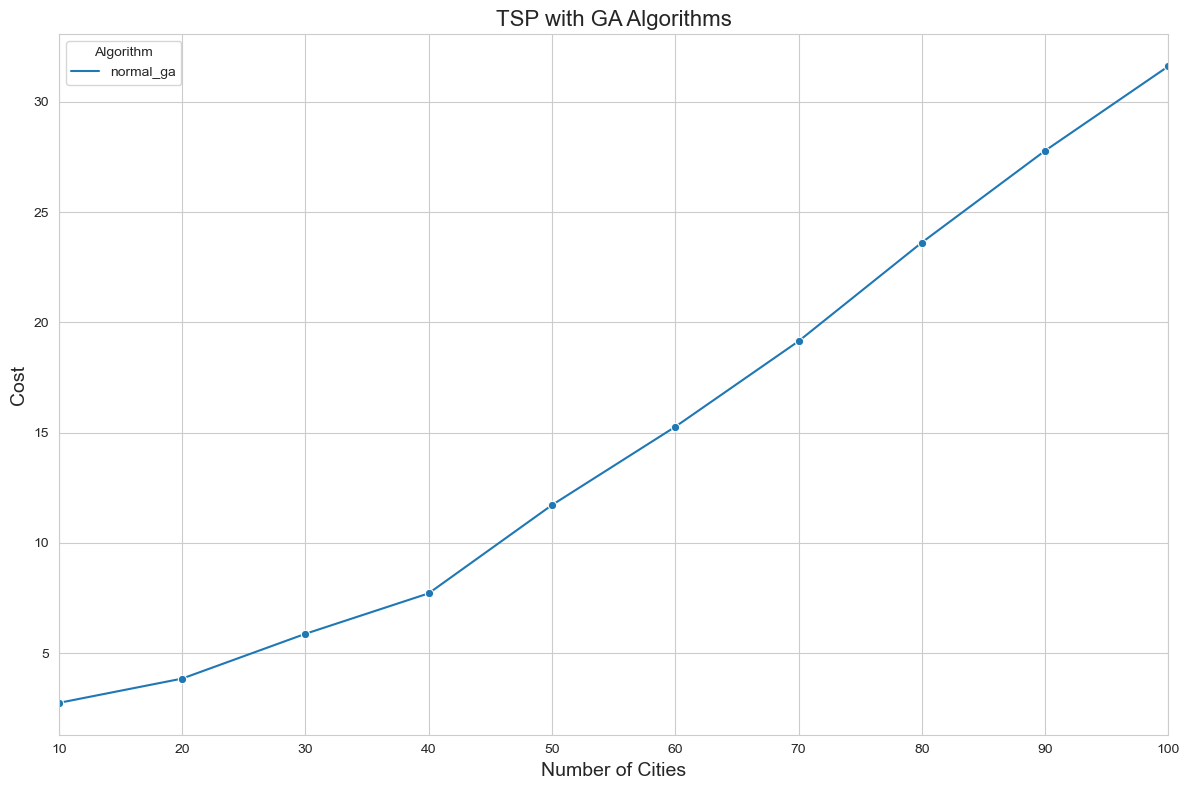

/Users/ckingersoll/miniconda3/envs/usml_base_ds_2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ckingersoll/miniconda3/envs/usml_base_ds_2/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


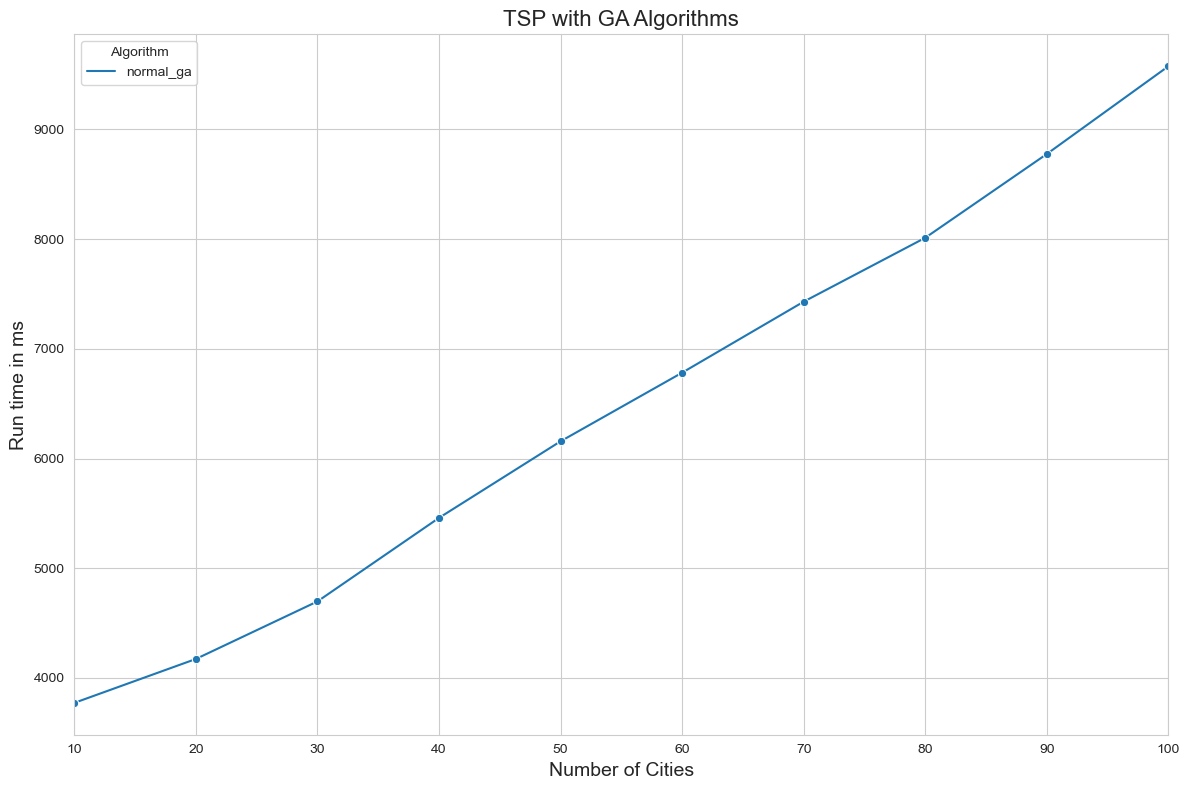

In [35]:
# plot the results averaging by number of cities and algorithm
#results_df = pd.DataFrame(results_ga_crispr)
#average_results = results_df.groupby(['n_cities', 'algo']).mean().reset_index()
#
#sns.set_style("whitegrid")
#plt.figure(figsize=(12, 8))
#sns.lineplot(data=average_results, x='n_cities', y='fitness', hue='algo', marker='o')
#plt.title('TSP with GA Algorithms', fontsize=16)
#plt.xlabel('Number of Cities', fontsize=14)
#plt.ylabel('Cost', fontsize=14)
#plt.legend(title='Algorithm')
#plt.xlim(10, 100)
#plt.tight_layout()
#plt.show()
#
# plot runtime results 
#sns.set_style("whitegrid")
#plt.figure(figsize=(12, 8))
#sns.lineplot(data=average_results, x='n_cities', y='time', hue='algo', marker='o')
#plt.title('TSP with GA Algorithms', fontsize=16)
#plt.xlabel('Number of Cities', fontsize=14)
#plt.ylabel('Run time in ms', fontsize=14)
#plt.legend(title='Algorithm')
#plt.xlim(10, 100)
#plt.tight_layout()
#plt.show()